<a href="https://colab.research.google.com/github/jbrazonath/CEIA_Analisis_de_datos/blob/main/CNN_implementacion_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importar lo necesario y establecemos la configuracines necesarias

In [1]:
import torch # pytorch
import torchvision # para cargar datasets y transformaciones
import random # para generar numeros aleatorios y probar nuestro modelo entrenado (buscando aleatoriamente ejemplos)
import matplotlib.pyplot as plt # para graficar
from tqdm import tqdm # para graficar la barra de avance
import wandb # hacer log en wheights and bias
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingWarmRestarts # modificar LR conforme se entrena

KeyboardInterrupt: 

In [ ]:
# instalar torchinfo para ver el modelo y sus parametros
!pip install torchinfo
import torchinfo as torchinfo

### configuramos el `device` acorde al device disponible




In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### nos vinculamos al weights and biases

In [ ]:
# key de Marcos Uriel Maillot (lelectronfou@gmail.com), cámbiela a su usario una vez finalizada la clase.
wandb.login(key="d63a15806a812590a5525d000eed0e6d6c57a023")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lelectronfou (mmaillot) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True



## Ejemplo de red neuronal de convolución (CNN)
**MNIST data base**
Vamos a usar la base de datos de MNIST ([ver fuente](http://yann.lecun.com/exdb/mnist/)) para entrenar una CNN que identifique números escritos a mano.

Para esto necesitamos:


1.   Cargar la base de datos.
2.   Ver que la base de datos esté ok.
3.   Construir nuestra CNN.
4. Ver que las dimensiones de la red sean consistentes.
4.   Definir funciones necesarias (de entrenamiento, de costo, etc.).
5. Entrenar la red.
6. Ver que funcione.






## 1. Cargar base de datos

De la documentación, ver:


Transformación `torchvision.transforms.ToTensor()`

```
... Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]...
```

Transformación `Normalize`

```
... Normalize a tensor image with mean and standard deviation. ...
```

In [ ]:
# definimos un conjunto de transformaciones para el dataset MNIST
# (pasamos de imagenes de 28x28 a tensores, normalizamos, etc.)
tranformaciones = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),#<---------------- escala entre 0 y 1; pasa a tensor; poner canal en 1ra dim
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))#<----------------- normaliza el dataset; media y desviación estándar de los datos
                            ])


# creamos el dataset (para cargar los datos a procesar) MNIST de entrenamiento y test
# (descargamos los datos si no están en la carpeta ../data)
train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True,
                       transform=tranformaciones
                      )

test_dataset = torchvision.datasets.MNIST('../data', train=False,
                   transform=tranformaciones
                     )

## aquí puede practicar por fuera de la clase, empleando otros datasets de torchvision.datasets, como CIFAR10, FashionMNIST, etc.
# para eso debe cargar el dataset deseado, por ejemplo:
# FASHIONMNIST, CIFAR10, etc. (ver https://pytorch.org/vision/stable/datasets.html)

# si desea trabajar con FashionMNIST, puede usar el siguiente código (descomentar):
# train_dataset = torchvision.datasets.FashionMNIST('../data', train=True, download=True, transform=tranformaciones)
# test_dataset = torchvision.datasets.FashionMNIST('../data', train=False, download=True, transform=tranformaciones)

# o si desea trabajar con CIFAR10, puede usar el siguiente código (descomentar):
# train_dataset = torchvision.datasets.CIFAR10('../data', train=True, download=True, transform=tranformaciones)
# test_dataset = torchvision.datasets.CIFAR10('../data', train=False, download=True, transform=tranformaciones)
#
# cuando corra estos otros datasets, recuerde que las transformaciones deben ser las adecuadas para cada dataset
# y que su arquitectura de red debe ser acorde a las dimensiones de las imágenes y al número de clases del dataset.

# ahora creamos el dataloader (recordar, dataloader -> una herramienta para hacer batches de datasets)
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.96MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.60MB/s]


## 2. Ver que la base de datos esté OK

In [ ]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
# Ver imagen and label del dataloader
train_features, train_labels = next(iter(dataloader['train']))

In [ ]:
# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")


Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])


tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


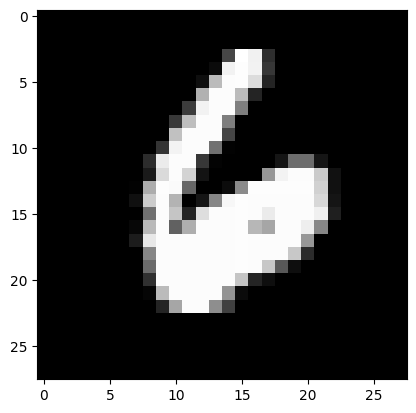

Label: 6


In [ ]:
# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[10]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[10]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
print('pixel [0,0]: ',img[0][0])
print('pixel maximo: ', torch.max(img))
print('pixel minimo: ', torch.min(img))

pixel [0,0]:  tensor(-0.4242)
pixel maximo:  tensor(2.8215)
pixel minimo:  tensor(-0.4242)


## 3. Construyo mi CNN

#### Bloque de convolución

defino primero un "bloque" de una capa CNN
construido con los bloques funcionales vistos en clase

argumentos a pasar a la función:

  - `c_in`:   canales (kernels) de entrada
  - `c_out`:  canales (kernels) de salida
  - `k`:      tamaño del kernel kxk
  - `p`:      tamaño del padding de la convolución
  - `s`:      stride de la convolución
  - `pk`:     tamaño del kernel del pooling


la función pooling se elige directamente dentro del bloque!

In [ ]:
# bloque de convolución para emplear en mi red
# esta función la utilizaré en la clase del a CNN

def conv_block(c_in, c_out, k=3, p='same', s=1, pk=2):
    return torch.nn.Sequential(                               # el módulo Sequential se engarga de hacer el forward de todo lo que tiene dentro.
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk)                                # pooling
    )


### Red convolucional (modelo)


Ahora SI construyo mi red... usando la clase CNN de pytorch
revisar muy bien las dimensiones a emplear en cada capa y
tener presente la reducción de las dimensiones.

En la útlima capa fully conected `fc`, hacer bien el cálculo final del
tamaño del array que se obtiene siguiendo la formula vista en la teoria
tanto para la capa conv como para la capa pooling.

In [ ]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    # aquí defino la arquitectura de mi red convolucional
    self.conv1 = conv_block(c_in = n_channels, c_out = 8, k=11, p='same', s=1, pk=2)
    self.conv1_out = None
    self.drop = torch.nn.Dropout2d(p=0.7, inplace=False)
    self.conv2 = conv_block(c_in = 8, c_out = 8, k=11, p='same', s=1, pk=2)
    self.conv2_out = None
    self.conv3 = conv_block(c_in = 8, c_out = 8, k=11, p='same', s=1, pk=2)
    self.conv3_out = None
    self.fc = torch.nn.Linear(8*3*3, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!

    # aquí imprimo la arquitectura de la red y el número de parámetros entrenables
    print('----------------------------------')
    print('Red creada')
    print('arquitectura:')
    print(self)

    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('----------------------------------')
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('----------------------------------')
    print('Número total de parámetros a entrenar: ', pytorch_total_params)
    print('----------------------------------')

  # aquí defino el método forward, que es el que se ejecuta cuando llamo a la red con un input
  def forward(self, x):
    #print('input shape: ', x.shape)
    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out
    y = y.flatten(start_dim=1)
    #print(y.shape)
    y = self.fc(y)
    return y


In [ ]:
# instancio modelo
model = CNN()

# armo config
# OJO!! NO ESTÁ AUTOMATIZADO!
# lo hago así para que tomen práctica sobre donde modificar en el código los
# hyperparámetros de la red y el entrenamiento.
model_config = {
        "num_layers": 4,
        "kernel_size": 11,
        "dropout": 0.7,
        "n_channels": [8, 8, 8],
        "architecture": model.__class__.__name__
  }


----------------------------------
Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=72, out_features=10, bias=True)
)
----------------------------------
Número total de capas de CNN (conv+act+polling) + finales :  5
----------------------------------
Número total de parámetros a entrenar:  17210
----------------------------------


In [ ]:
model_config

{'num_layers': 4,
 'kernel_size': 11,
 'dropout': 0.7,
 'n_channels': [8, 8, 8],
 'architecture': 'CNN'}

## 4. Veamos que las dimensiones sean consistentes.

In [ ]:
# corremos el resumen de la red para ver los parámetros y tamaños intermedios
# es necesario pasarle el tamaño de la entrada, que en este caso es (batch_size, n_channels, height, width)
torchinfo.summary(model, input_size=( 64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Sequential: 1-1                        [64, 8, 14, 14]           --
│    └─Conv2d: 2-1                       [64, 8, 28, 28]           976
│    └─Tanh: 2-2                         [64, 8, 28, 28]           --
│    └─MaxPool2d: 2-3                    [64, 8, 14, 14]           --
├─Dropout2d: 1-2                         [64, 8, 14, 14]           --
├─Sequential: 1-3                        [64, 8, 7, 7]             --
│    └─Conv2d: 2-4                       [64, 8, 14, 14]           7,752
│    └─Tanh: 2-5                         [64, 8, 14, 14]           --
│    └─MaxPool2d: 2-6                    [64, 8, 7, 7]             --
├─Dropout2d: 1-4                         [64, 8, 7, 7]             --
├─Sequential: 1-5                        [64, 8, 3, 3]             --
│    └─Conv2d: 2-7                       [64, 8, 7, 7]             7,752
│    └─T

## 5. Armo las funciones necesarias

In [ ]:
# definimo optimizer y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# paso al config el optimizador
model_config["optimizer"] = optimizer.__class__.__name__

# defino función de perdida
loss_fn = torch.nn.CrossEntropyLoss()


# Scheduler
scheduler_type = "step"
steps_per_epoch = len(dataloader['train'])
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=steps_per_epoch, T_mult=2, eta_min=1e-5)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-2, step_size_up=steps_per_epoch, mode="triangular2")

## Si queremos aplicar cambios al learning rate al final de cada epoch, usamos como ejemplo otro como este:
#scheduler_type = "epoch"
#scheduler = ExponentialLR(optimizer, gamma=0.99) # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate


In [ ]:
# armamos una función para entrenar el modelo con logeo de Weights & Biases (wandb)
# a esta función hay que pasarle el modelo, el optimizador, los dataloaders de entrenamiento y evaluación,
# la función de pérdida, el config y otros parámetros de configuración.

def train_model_wandb(
        model,
        optimizer,
        train_loader,
        eval_loader,
        loss_module,
        config = model_config,
        scheduler_type="step",
        patience=3,
        patience_factor=0.01,
        num_epochs=3,
        scheduler = scheduler
):
    # Initialize Weights & Biases
    # el nombre del proyecto es "CEIA-Co[NUMERO_DE_COHORTE]", y el config es el que armamos antes
    # para que quede guardado en el log de wandb y podamos conocer los hyperparámetros empleados
    # en ese entrenamiento
    wandb.init(project="CEIA-Co22-CNN-mnist", config=config)

    ## Set device
    model.to(device)

    # Set metric for callbacks
    best_eval = 0
    pt_epoch = 0

    for epoch in tqdm(range(num_epochs), desc="Epoch Progress"):
        ### Training Phase ###
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_samples = 0

        for batch_idx, data in enumerate(train_loader):

            X, y = data
            # Move input data to device (if using GPU)
            data_inputs = X.to(device)
            data_labels = y.to(device)

            # Forward pass
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Ensure shape consistency

            # Compute loss
            loss = loss_module(preds, data_labels)

            # Zero gradients, backpropagate, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss for this batch
            batch_loss = loss.item()
            train_loss += batch_loss

            # Compute accuracy (assuming classification task)
            if preds.ndim == 2:  # Softmax case
                preds_classes = preds.argmax(dim=1)
            else:  # Sigmoid case (binary classification)
                preds_classes = (preds > 0.5).long()

            train_correct += (preds_classes == data_labels).sum().item()
            train_samples += data_labels.size(0)

            # Log batch-wise metrics
            wandb.log({
                "batch_loss": batch_loss,
                "batch_step": epoch * len(train_loader) + batch_idx,
                "batch_lr": optimizer.param_groups[0]['lr'],
            })

            # Step-level callback
            if scheduler_type=="step":
                scheduler.step()

        # Compute training metrics
        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_samples

        ### Evaluation Phase ###
        model.eval()
        eval_loss = 0.0
        eval_correct = 0
        eval_samples = 0

        with torch.no_grad():  # Disable gradient tracking
            for data in eval_loader:

                X, y = data
                data_inputs = X.to(device)
                data_labels = y.to(device)

                preds = model(data_inputs)
                preds = preds.squeeze(dim=1)

                loss = loss_module(preds, data_labels)
                eval_loss += loss.item()

                if preds.ndim == 2:
                    preds_classes = preds.argmax(dim=1)
                else:
                    preds_classes = (preds > 0.5).long()

                eval_correct += (preds_classes == data_labels).sum().item()
                eval_samples += data_labels.size(0)

        # Compute evaluation metrics
        eval_loss /= len(eval_loader)
        eval_accuracy = eval_correct / eval_samples

        # Log epoch-level metrics
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "eval_loss": eval_loss,
            "eval_accuracy": eval_accuracy,
            "learning_rate": optimizer.param_groups[0]['lr'],
        })

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} | Eval Loss: {eval_loss:.4f} - Eval Acc: {eval_accuracy:.4f}")

        # Callbacks
        ## Learning rate scheduler
        if scheduler_type=="epoch":
            scheduler.step()
        ## Early stopping
        if eval_accuracy>=best_eval*(1+patience_factor):
            best_eval = eval_accuracy
            pt_epoch = 0
        else:
            pt_epoch += 1
            if pt_epoch>=patience:
                print(f"Epoch {epoch+1}/{num_epochs} - Training interrupted due to early stopping condition.")
                wandb.finish()
                break
            else:
                print(f"Epoch {epoch+1}/{num_epochs} - Current epochs without validation metric improvement {pt_epoch}. {patience-pt_epoch} remaining before stopping.")

    # Finish W&B run
    wandb.finish()

## 6. Entrenamiento WandB

In [ ]:
# corremos la función de entrenamiento con todos los argumentos correspondientes
train_model_wandb(model, optimizer, dataloader['train'], dataloader['test'], loss_fn, scheduler_type=scheduler_type, num_epochs=15)

Epoch Progress:   7%|▋         | 1/15 [00:19<04:29, 19.27s/it]

Epoch 1/15 - Train Loss: 1.8599 - Train Acc: 0.4296 | Eval Loss: 1.2771 - Eval Acc: 0.6965


Epoch Progress:  13%|█▎        | 2/15 [00:38<04:10, 19.30s/it]

Epoch 2/15 - Train Loss: 1.2081 - Train Acc: 0.6414 | Eval Loss: 0.7159 - Eval Acc: 0.7849


Epoch Progress:  20%|██        | 3/15 [00:57<03:48, 19.01s/it]

Epoch 3/15 - Train Loss: 0.9928 - Train Acc: 0.6901 | Eval Loss: 0.6475 - Eval Acc: 0.8071


Epoch Progress:  27%|██▋       | 4/15 [01:16<03:29, 19.06s/it]

Epoch 4/15 - Train Loss: 0.8912 - Train Acc: 0.7180 | Eval Loss: 0.4860 - Eval Acc: 0.8567


Epoch Progress:  33%|███▎      | 5/15 [01:35<03:09, 18.93s/it]

Epoch 5/15 - Train Loss: 0.7846 - Train Acc: 0.7491 | Eval Loss: 0.4110 - Eval Acc: 0.8766


Epoch Progress:  40%|████      | 6/15 [01:54<02:51, 19.02s/it]

Epoch 6/15 - Train Loss: 0.7352 - Train Acc: 0.7634 | Eval Loss: 0.3790 - Eval Acc: 0.8871


Epoch Progress:  47%|████▋     | 7/15 [02:13<02:31, 18.96s/it]

Epoch 7/15 - Train Loss: 0.7172 - Train Acc: 0.7691 | Eval Loss: 0.3679 - Eval Acc: 0.8904
Epoch 7/15 - Current epochs without validation metric improvement 1. 2 remaining before stopping.


Epoch Progress:  53%|█████▎    | 8/15 [02:32<02:13, 19.06s/it]

Epoch 8/15 - Train Loss: 0.6841 - Train Acc: 0.7783 | Eval Loss: 0.3102 - Eval Acc: 0.9072


Epoch Progress:  60%|██████    | 9/15 [02:51<01:53, 18.96s/it]

Epoch 9/15 - Train Loss: 0.6357 - Train Acc: 0.7927 | Eval Loss: 0.2757 - Eval Acc: 0.9151
Epoch 9/15 - Current epochs without validation metric improvement 1. 2 remaining before stopping.


Epoch Progress:  67%|██████▋   | 10/15 [03:10<01:35, 19.06s/it]

Epoch 10/15 - Train Loss: 0.6025 - Train Acc: 0.8009 | Eval Loss: 0.2511 - Eval Acc: 0.9227


Epoch Progress:  73%|███████▎  | 11/15 [03:29<01:15, 18.92s/it]

Epoch 11/15 - Train Loss: 0.5892 - Train Acc: 0.8039 | Eval Loss: 0.2371 - Eval Acc: 0.9270
Epoch 11/15 - Current epochs without validation metric improvement 1. 2 remaining before stopping.


Epoch Progress:  80%|████████  | 12/15 [03:48<00:57, 19.03s/it]

Epoch 12/15 - Train Loss: 0.5714 - Train Acc: 0.8090 | Eval Loss: 0.2276 - Eval Acc: 0.9295
Epoch 12/15 - Current epochs without validation metric improvement 2. 1 remaining before stopping.
Epoch 13/15 - Train Loss: 0.5611 - Train Acc: 0.8116 | Eval Loss: 0.2221 - Eval Acc: 0.9313
Epoch 13/15 - Training interrupted due to early stopping condition.


batch_loss,██▆▆▅▅▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▂▂▂▁▂▂▁
batch_lr,███▄▂▇▃▂▂█▇▆▅▅▄▂▂▂▂▂▁▁████▇▇▇▇▆▆▆▅▅▄▃▃▃▂
batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
eval_accuracy,▁▄▄▆▆▇▇▇█████
eval_loss,█▄▄▃▂▂▂▂▁▁▁▁▁
learning_rate,█▄█▇▄▁██▇▅▄▂▁
train_accuracy,▁▅▆▆▇▇▇▇█████
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁
batch_loss,0.61357
batch_lr,2e-05


Epoch Progress:  80%|████████  | 12/15 [04:07<01:01, 20.61s/it]


## 7. Vemos que funcione.

Tamaño del batch de feature (input / imagen): 64
torch.Size([1, 28, 28])


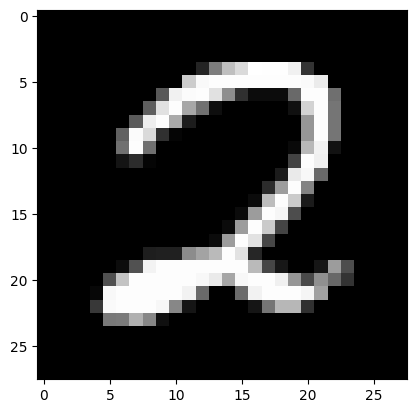

Tamaño imagen de entrada a red:  torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[-0.1152, -1.5734,  7.9792,  2.0501, -4.7255,  0.6155, -3.4550, -0.6987,
         -0.7724, -1.9042]], device='cuda:0')

softmax de predicción:
tensor([[3.0401e-04, 7.0729e-05, 9.9595e-01, 2.6499e-03, 3.0245e-06, 6.3129e-04,
         1.0775e-05, 1.6961e-04, 1.5756e-04, 5.0807e-05]], device='cuda:0')

El numero es un:  2


In [ ]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader de testeo
test_features, test_labels = next(iter(dataloader['test']))
# obtengo el tamaño del batch
print(f"Tamaño del batch de feature (input / imagen): {test_features.size(0)}")

# generamos un índice aleatorio para tomar una imagen del batch
k = random.randint(0, test_features.size(0) - 1)

# verifico las dimensiones
samp_img = test_features[k]
print(samp_img.shape)


# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_imp.to(device) # aseguro que la imagen esté en el device correcto (GPU o CPU)
print('Tamaño imagen de entrada a red: ', samp_img.shape)

# la paso al modelo
model.to(device)
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())
